In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Bibliotecas

In [3]:
%matplotlib inline
!pip install mne
!pip install fooof
!pip install fieldtrip2mne
!pip install PyWavelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 82.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 9.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fieldtrip2mne: filename=fieldtrip2mne-0.0.7-py3-none-any.whl size=8653 sha256=3d4dec0c4a863eb8ef32d2742973ce695101b1ef31298b6db3d5334abf812a55
  Stored in directory: /root/.cache/pip/wheels/ed/59/f7/b236e08dab7b68c61cef04e39ec19d52dcdf2d2edbf83d9b39
Successfully built fieldtrip2mne
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#manejo de elemeotos del sistema, como carpetas
import scipy.io as sio;
import numpy as np;
from numpy.linalg import matrix_rank
import glob
import os
import copy
import pickle

# General imports
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar
import pandas as pd


#importamos la rutina de welch
from scipy.signal import welch as pwelch
from scipy.signal import butter, lfilter
from scipy import signal as sg
import pywt
#from wavelet_filtering import wnoisest, wthresh, thselect


# Import MNE, as well as the MNE sample dataset
import mne
from mne import io
import tarfile
from fieldtrip2mne import read_epoched

# FOOOF imports
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum


In [5]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import tensorflow as tf
# Setting seed for reproducibility
n_seed = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split

from keras.models import Sequential,load_model,model_from_json
from keras.layers import Dense, Dropout, LSTM,BatchNormalization,TimeDistributed,Flatten,Bidirectional


# Clasificación de grupos

In [6]:
def get_age(x):
  low,high = x.split('-')
  low = int(low)
  high = int(high)
  return np.mean([low,high])

def get_age_group(x):
  if x >= 60:
    return 1 #'AdultoMayor'
  else:
    return 0 #'Adulto'

# Preparación de datos para el modelo

In [17]:
def powers(senal_continua,fs):
  nperseg = int(fs*2)
  noverlap = int(nperseg/2);
  max_frequency = 40
  potencia = np.zeros((19,5))

  #%% USANDO WELCH sobre todos los canales
  f, Pxx = pwelch(senal_continua, fs, 'hann', nperseg, noverlap);
  f=f[0,:]
  deltaIPEG = np.sum(Pxx[:,((f <= 6)& (f > 1.5))],axis=1) #1.5-6
  thetaIPEG = np.sum(Pxx[:,(f <= 8.5) & (f > 6)],axis=1)
  alfaIPEG = np.sum(Pxx[:,(f <= 12.5) & (f > 8.5)],axis=1)
  betaIPEG = np.sum(Pxx[:,(f <= 30) & (f > 12.5)],axis=1)
  gammaIPEG = np.sum(Pxx[:,(f <= 40) & (f > 30)],axis=1)

  total = np.sum(Pxx[:,(f <= max_frequency) & (f > 1.5)],axis=1)
  deltaIPEG_relativo = deltaIPEG/total
  thetaIPEG_relativo = thetaIPEG/total
  alfaIPEG_relativo = alfaIPEG/total
  betaIPEG_relativo = betaIPEG/total
  gammaIPEG_relativo = gammaIPEG/total

  potencia[:,0] = deltaIPEG_relativo
  potencia[:,1] = thetaIPEG_relativo
  potencia[:,2] = alfaIPEG_relativo
  potencia[:,3] = betaIPEG_relativo
  potencia[:,4] = gammaIPEG_relativo

  return (potencia)

In [8]:
def get_model_data(set_path,band=(12,30)):
  dummyset = sio.loadmat(set_path)
  #print(dummyset.keys())
  nchannels_set,npoints_set,nepochs_set = np.dstack(dummyset['segments']).shape
  dummyset_continuo = np.hstack(dummyset['segments'])
  dummyset_S_continuo = dummyset['W'] @ (dummyset_continuo)
  #dummyset_S_continuo = dummyset_continuo
  #print(nchannels_set,npoints_set,nepochs_set)
  dummyset_S_epocas = dummyset_S_continuo.reshape((dummyset_S_continuo.shape[0],npoints_set,nepochs_set),order='F')
  print(dummyset_S_epocas.shape)
  
  ch_types = ['eeg'] * dummyset_S_continuo.shape[0]
  dummyset_info = mne.create_info(dummyset_S_continuo.shape[0], sfreq=dummyset['sfreq'], ch_types=ch_types)
  dummy_raw = mne.io.RawArray(dummyset_S_continuo, dummyset_info)
  #dummy_raw.plot(show_scrollbars=False, show_scalebars=False)
  #dummy_raw.plot_psd()
  #comp_filter = dummy_raw.copy().filter(*band)
  #comp_filter = comp_filter.copy().resample(sfreq=128)
  #comp_filter.plot_psd()
  comp_filter = dummy_raw
  epocas = mne.make_fixed_length_epochs(comp_filter, duration=2, preload=True)
  comp = list(np.arange(epocas._data.shape[1]).astype(int))
  #[3,4,5,6,7,8,9,10,11,12,14,16,17,18]
  #segments = [wavelet_decomposition(epocas._data[e,comp,:])['alpha'] for e in range(epocas._data.shape[0])]
  segments = [powers(epocas._data[e,comp,:],dummyset['sfreq']) for e in range(epocas._data.shape[0])]
  #print(dummyset.keys())
  print(segments[0].shape)
  age = dummyset['Age'].tolist()[0]
  #print(age)
  age = get_age(age)
  age = get_age_group(age)
  #print(age)
  return segments,[age]*len(segments)

In [9]:
def traindata(archivos):
  train_filename = your_path + '/HENAO ISAZA VERÓNICA/Data/train_data.mat'
  overwrite = True
  if not os.path.isfile(train_filename) or overwrite:
    ejemplos = []
    grupos = [] 
    for i,archivo in enumerate(archivos[:10]):
      print('**********************************')
      print(i,archivo)
      epocas,edades=get_model_data(archivo)
      ejemplos += epocas
      grupos += edades
      print('**********************************')
    X = np.array(ejemplos)
    Y = np.array(grupos)
    sio.savemat(train_filename,{'X':X,'Y':Y})
  else:
    print('File existed')
    train_data = sio.loadmat(train_filename)
    X = train_data['X']
    Y = np.squeeze(train_data['Y'])
  return X,Y

# Balancear datos

In [10]:
def balance(X,Y):
  X=X/np.max(X)
  Y_1 = np.sum(Y)
  Y_0 = Y.shape[0] - Y_1
  Y_1p = 100*Y_1/Y.shape[0]
  Y_0p = 100-Y_1p

  print('Y_1',Y_1p,Y_1)
  print('Y_0',Y_0p,Y_0)
  N_remove = np.abs(Y_0 - Y_1)
  print(N_remove)
  N_keep = np.min([Y_0,Y_1])
  print(N_keep)
  idx_0 = np.where(Y==0)
  idx_0
  assert np.sum(Y[idx_0])==0
  idx_1 = np.where(Y==1)[0]
  tf.random.set_seed(n_seed)
  rng = np.random.default_rng(n_seed)
  idx_to_keep = rng.choice(idx_0[0], N_keep, replace=False)
  assert N_keep == len(set(idx_to_keep.tolist()))
  idx_to_keep=np.sort(np.concatenate([idx_to_keep,idx_1]))
  assert np.sum(Y[idx_to_keep])==Y_1 # Adultos mayores antes == Adultos mayores despues
  assert np.sum(Y[idx_to_keep]==0)==Y_1 # Adultos mayores antes == Adultos despues
  X_ = X[idx_to_keep,:]
  Y_ = Y[idx_to_keep]
  X_train, X_test, Y_train, Y_test = train_test_split(
    X_, Y_, test_size=0.3, stratify=Y_,random_state=n_seed)
  return X_train, X_test, Y_train, Y_test


In [11]:
def rename(X_train, X_test, Y_train, Y_test):
  train_X = X_train
  train_label = Y_train
  test_X = X_test
  test_label = Y_test
  print(train_X.shape)
  print(train_label.shape)
  print(test_X.shape)
  print(test_label.shape)
  return train_X,test_X,train_label,test_label

# Entrada al modelo

In [12]:
def inModel(Y_train,Y_test):
  train_1 = 100*np.sum(Y_train)/Y_train.shape[0]
  train_0 = 100-train_1
  test_1 = 100*np.sum(Y_test)/Y_test.shape[0]
  test_0 = 100-test_1
  print('Train:',train_1,train_0)
  print('Test:',test_1,test_0)


# Cargar datos

Debido a que no se encuentra en una unidad compartida, se hace necesario colocar la dirección personal del Drive donde se aloja la carpeta HENAO ISAZA VERÓNICA

In [13]:
your_path = '/content/drive/MyDrive/'

## Elegir tipo de datos

Para probar el modelo con ambos tipos de datos (Crudos y preprocesados) se debe modificar la bandera **Preprocesamiento** segun la necesidad.

In [14]:
#Si preprocesamiento esta en True, se ejecutara el modelo con los datos preprocesados
Preprocesamiento = False

In [15]:
if Preprocesamiento is True:
  path_archivos = your_path + '/HENAO ISAZA VERÓNICA/Data/Datos_mat_Preprocesados/*.mat'
  archivos = glob.glob(path_archivos)
  model_name = your_path + '/HENAO ISAZA VERÓNICA/Model/Modelo_Preprocesados'
else:
  path_archivos = your_path + '/HENAO ISAZA VERÓNICA/Data/Datos_mat_Crudos/*.mat'
  archivos = glob.glob(path_archivos)
  model_name = your_path + '/HENAO ISAZA VERÓNICA/Model/Modelo_Crudos'

# Ejecutar funciones

In [19]:
X,Y = traindata(archivos)

**********************************
0 /content/drive/MyDrive//HENAO ISAZA VERÓNICA/Data/Datos_mat_Crudos/sub-032444.mat
(19, 1000, 232)
Creating RawArray with float64 data, n_channels=19, n_times=232000
    Range : 0 ... 231999 =      0.000 ...   463.998 secs
Ready.
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 232 events and 1000 original time points ...
0 bad epochs dropped
(19, 5)
**********************************
**********************************
1 /content/drive/MyDrive//HENAO ISAZA VERÓNICA/Data/Datos_mat_Crudos/sub-032448.mat
(19, 1000, 232)
Creating RawArray with float64 data, n_channels=19, n_times=232000
    Range : 0 ... 231999 =      0.000 ...   463.998 secs
Ready.
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 232 events and 1000 original time points ...
0 bad epochs dropped
(19, 5)
*

In [20]:
X_train, X_test, Y_train, Y_test = balance(X,Y)
train_X,test_X,train_label,test_label = rename(X_train, X_test, Y_train, Y_test)

Y_1 30.0 696
Y_0 70.0 1624
928
696
(974, 19, 5)
(974,)
(418, 19, 5)
(418,)


In [21]:
inModel(Y_train,Y_test)

Train: 50.0 50.0
Test: 50.0 50.0


# Modelo

In [22]:
from tensorflow.keras import layers
from tensorflow.keras import initializers

In [26]:
tf.random.set_seed(n_seed)
kernel_initializer=initializers.RandomNormal(stddev=0.01,seed=(n_seed))
nb_features = train_X.shape[2]
sequence_length = train_X.shape[1]

model = Sequential()

model.add(Bidirectional(LSTM( units=256,
        return_sequences=True,kernel_initializer=kernel_initializer),
        input_shape=(sequence_length,nb_features),
        ))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(
        units=128,
        return_sequences=True,kernel_initializer=kernel_initializer))

model.add(BatchNormalization())
model.add(LSTM(
          units=64,
          return_sequences=False,kernel_initializer=kernel_initializer))

model.add(BatchNormalization())
model.add(Dense(units=32,kernel_initializer=kernel_initializer))
model.add(Dense(units=1, activation='sigmoid',kernel_initializer=kernel_initializer))
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adam')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 19, 512)          536576    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 19, 512)           0         
                                                                 
 batch_normalization_9 (Batc  (None, 19, 512)          2048      
 hNormalization)                                                 
                                                                 
 lstm_10 (LSTM)              (None, 19, 128)           328192    
                                                                 
 batch_normalization_10 (Bat  (None, 19, 128)          512       
 chNormalization)                                                
                                                      

# Entrenamiento

In [ ]:
history = model.fit(train_X, train_label,validation_split=0.1,epochs=50, batch_size=32,verbose=1)

Epoch 1/50
46/46 [==============================] - 17s 88ms/step - loss: 0.5149 - accuracy: 0.7947 - val_loss: 0.6746 - val_accuracy: 0.6380
Epoch 2/50
46/46 [==============================] - 2s 42ms/step - loss: 0.4334 - accuracy: 0.8179 - val_loss: 0.7003 - val_accuracy: 0.4663
Epoch 3/50
46/46 [==============================] - 2s 42ms/step - loss: 0.4008 - accuracy: 0.8303 - val_loss: 0.6863 - val_accuracy: 0.4663
Epoch 4/50
46/46 [==============================] - 2s 42ms/step - loss: 0.3703 - accuracy: 0.8323 - val_loss: 0.5767 - val_accuracy: 0.8528
Epoch 5/50
46/46 [==============================] - 2s 42ms/step - loss: 0.3328 - accuracy: 0.8528 - val_loss: 0.6867 - val_accuracy: 0.5583
Epoch 6/50
46/46 [==============================] - 2s 43ms/step - loss: 0.3268 - accuracy: 0.8638 - val_loss: 1.0683 - val_accuracy: 0.4663
Epoch 7/50
46/46 [==============================] - 2s 42ms/step - loss: 0.3240 - accuracy: 0.8556 - val_loss: 0.6466 - val_accuracy: 0.5215
Epoch 8/50
4

No handles with labels found to put in legend.


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 432x288 with 0 Axes>

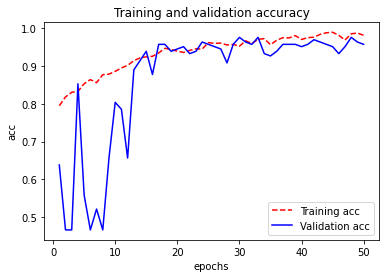

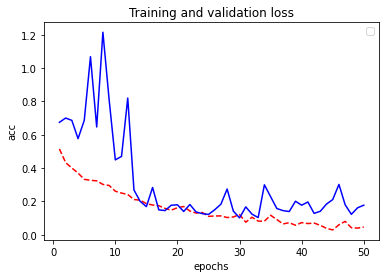

<Figure size 432x288 with 0 Axes>

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc      = history.history[ 'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--' )
plt.plot ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

# Guardar modelo

In [ ]:
def toJSON(model,path):
  # serialize model to JSON
  model_json = model.to_json()
  with open(path+'.json', "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(path+'.h5')
  print("Saved model to disk")

In [ ]:
def loadModel(path):
  # load json and create model
  json_file = open(path+'.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights(path+'.h5')
  print("Loaded model from disk")
  return loaded_model

# Graficar matriz de confusión

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# compute precision and recall
def computerprecision(test_label,classes_x):
  precision_test = precision_score(test_label,classes_x)
  recall_test = recall_score(test_label, classes_x)
  f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
  print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

In [ ]:
def vs(scores_test_Pre,scores_test_Cru):

  plt.figure(figsize = (12,7))  
  ## Declaramos valores para el eje x
  x_labels = ['Preprocessed','Raw']  
  ## Declaramos valores para el eje y
  eje_y = [scores_test_Pre[1]*100,scores_test_Cru[1]*100]

  plt.bar(x_labels, eje_y, width= 0.9, align='center',color='0.8')
  for i in range(len(x_labels)):
      plt.annotate(round(eje_y[i]),xy=(i,eje_y[i]),color='Black', weight='bold', ha='center',  size=20)
  plt.legend(labels = ['Accuracy percentage'])
  plt.title("Dataset")
  plt.xlabel('Data')
  plt.ylabel('Accurracy')
  plt.ylim((90,100))
  # Saving the plot as a 'png'
  plt.savefig(model_name+'.png')
  plt.show()


In [ ]:
toJSON(model,model_name)
loaded_model =loadModel(model_name)
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
if Preprocesamiento is True:
  scores_test_Pre = loaded_model.evaluate(test_X,test_label, verbose=2)
else:
  scores_test_Cru = loaded_model.evaluate(test_X,test_label, verbose=2)

predict_x=loaded_model.predict(test_X) 
classes_x=(predict_x>= 0.5).astype(int)
cm_test = confusion_matrix(test_label,classes_x)
computerprecision(test_label,classes_x)
print(model_name)
# loaded_model(test_data)

Saved model to disk
Loaded model from disk
22/22 - 4s - loss: 0.1645 - accuracy: 0.9583 - 4s/epoch - 160ms/step
Precision:  0.9467787114845938 
 Recall:  0.9712643678160919 
 F1-score: 0.9588652482269504
/content/drive/MyDrive/Fundamentos de Deep learning/Proyecto/HENAO ISAZA VERÓNICA/Model/Modelo_Crudos


In [ ]:
try: 
  scores_test_Pre 
  print('Accurracy Pre: {}'.format(scores_test_Pre[1])) 
  try: 
    scores_test_Cru
    print('Accurracy Cru: {}'.format(scores_test_Cru[1]))

    vs(scores_test_Pre,scores_test_Cru)
  except: 
    pass
except:
  pass

Confusion matrix, without normalization
[[329  19]
 [ 10 338]]


<Figure size 432x288 with 0 Axes>

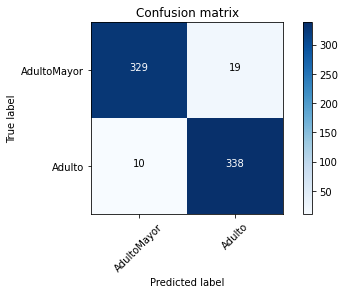

In [ ]:
# Plot non-normalized confusion matrix
class_names=['AdultoMayor','Adulto']
plt.figure()
plot_confusion_matrix(cm_test, classes=class_names,
                      title='Confusion matrix')
plt.savefig('Confusion matrix.png')
plt.show()